In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.optimize import minimize

As we know, the SVI model has the form:
$$ \sigma_{SVI}(k_{F},T) = \sqrt{a+b[\rho(lnk_{F}-m)+\sqrt{(lnk_{F}-m)^2 + s^2}]}$$
where $k_{F} = K/F$ is the forward-moneyness.

Here, in order to find model parameters, we perform a minimization against observed data.

In [2]:
# Data Cleaning
NDX_index = 5448
r = 0.0125
F = 5460
T = 349/365

# read data
file = '/Users/yusongpan/Desktop/HW2_data.csv'  
data = pd.read_csv(file,header = 5)
# change percentage object to float object
data['Implied Vol'] = data['Implied Vol. %'].str.rstrip('%').astype('float') / 100
data['Implied Vol.1'] = data['Implied Vol. %.1'].str.rstrip('%').astype('float') / 100
market_impliedvol = data[data.columns[12]].values
strike = data[data.columns[0]].values
k_F = (strike/F)
data.head()

,Strike,C,Bid,Ask,Mid,Implied Vol. %,Strike.1,P,Bid.1,Ask.1,Mid.1,Implied Vol. %.1,Implied Vol,Implied Vol.1
0,2700,C,2719.2,2738.9,2729.05,29.10%,2700,P,3.0,6.4,4.70,31.80%,0.291,0.318
1,2800,C,2621.6,2641.1,2631.35,29%,2800,P,3.0,7.4,5.20,30.70%,0.290,0.307
2,2900,C,2524.1,2543.6,2533.85,28.70%,2900,P,5.0,8.6,6.80,30.30%,0.287,0.303
3,3000,C,2427.0,2446.2,2436.60,28.50%,3000,P,6.0,9.9,7.95,29.50%,0.285,0.295
4,3100,C,2329.6,2349.1,2339.35,27.90%,3100,P,8.0,11.4,9.70,28.90%,0.279,0.289


In [3]:
# Minimization
def model(x,u):
    """
    x = [a,b,rho,m,s]
    u = K/F
    """
    return np.sqrt(x[0]+x[1]*(x[2]*(np.log(u)-x[3])+np.sqrt((np.log(u)-x[3])**2 + x[4]**2)))

def func(x,u,y):
    return sum((model(x,u)**2 - y**2)**2)

cons = ({'type':'ineq', 'fun': lambda x: x[0]},
        {'type':'ineq', 'fun': lambda x: x[1]},
        {'type':'ineq', 'fun': lambda x: 1-np.abs(x[2])},
        {'type':'ineq', 'fun': lambda x: 4-x[1]*(1+np.abs(x[2])*T)},
        {'type':'ineq', 'fun': lambda x: x[4]})


u = np.array(k_F)
y = market_impliedvol
x0 = np.array([0,0,0,0,0]) #initial guess [a,b,rho,m,s]
res = minimize(func,x0,args=(u,y),method = 'COBYLA',constraints = cons)
print("Thus the parameters of the SVI model against the market-implied volatility data is:", res.x.round(decimals=3))

Thus the parameters of the SVI model against the market-implied volatility data is: [0.002 0.11  0.036 0.138 0.13 ]


/Users/yusongpan/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt


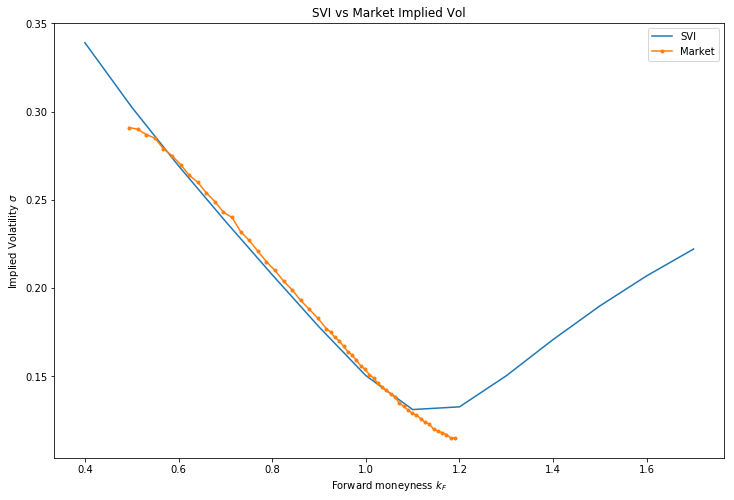

In [4]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(0.4,1.8,0.1),model(res.x,np.arange(0.4,1.8,0.1)))
plt.plot(u,market_impliedvol,'.-')
plt.xlabel("Forward moneyness $k_{F}$")
plt.ylabel('Implied Volatility $\sigma$')
plt.legend(['SVI','Market'],loc = 'best')
plt.title('SVI vs Market Implied Vol')
plt.show()